In [15]:
from serial.tools.list_ports import comports
for port in comports():
    print(port)

/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbserial-PX4IFKTF - Prologix GPIB-USB Controller


Program completed


'\n300 - 35  1.6  \n360 - 28  0.8\n420 - 21  0.4\n480 - 14  0.2\n540 - 7   0.1\n'

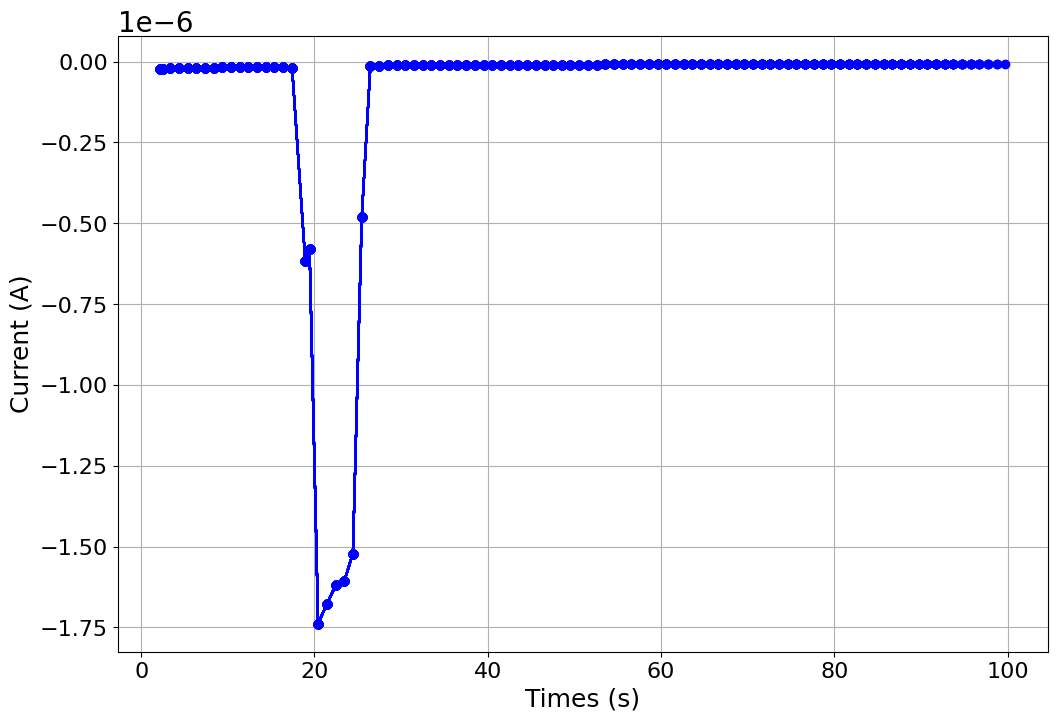

In [16]:
import os
import sys
import time
import csv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from Keithley617.Keithley617 import Keithley617 as smu
# Set parameters
source_voltage = -20 # V
duration = 100 #s -30min
delay_time = 1 #s 16h

# Set the filename
file_name = input('Enter file name: ')
filename = os.path.join(file_name + '.csv')

# Check Parameters
print(f'File name: {file_name}.csv')
print(f'Voltage: {source_voltage} V')
print(f'Delay time: {delay_time} s')
print(f'Duration: {duration} s')

# Open a connection to the Keithley 617
smu = smu('/dev/cu.usbserial-PX4IFKTF')

# Make sure if you start or not
START = input('Press Enter to Start')
if START == '':
    print("\n Let's get started :)")
    pass
else:
    sys.exit(0)

# Initialize the time and current arrays
times = []
currents = []
voltages = []

# Set up the real-time plot
plt.ion()
fig = plt.figure(figsize=(12,8))
plt.rcParams["font.size"] = 20
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')

if smu:
    # Set the parameters source to properly measure current
    smu.reading_mode('electrometer')
    smu.zero_check('off')
    smu.zero_correct('enabled')
    smu.set_function('amps')
    smu.data_format('without_prefix')
    smu.set_range('R0') # R0 - auto
    
    # Start the measurement and real-time plot
    start_time = time.perf_counter()
    
    # Turn on source output
    smu.source_output('on')
    while (time.perf_counter() - start_time) < duration:
        round_start = time.perf_counter()
        # Set the voltage source
        smu.set_voltage(source_voltage)
        clear_output(wait=True)

         # Measure current with retry mechanism
        current = None
        for _ in range(3):  # retry up to 3 times
            try:
                current = smu.measure_current()
                if current is not None:
                    break
            except Exception as e:
                print(f"Error measuring current: {e}")
                time.sleep(0.1)  # brief delay before retrying

        if current is None:
           # print("Failed to measure current after 3 attempts")
            continue
       
       
        times.append((time.perf_counter() - start_time))
        currents.append(current)
        voltages.append(source_voltage)
        print(f'Time: {times[-1]:.2f} s')
        print(f'Voltage: {source_voltage:.4g} V')
        print(f'Current: {current:.4g} A')
        plt.plot(times[-100:], currents[-100:], linestyle='-', marker='o', label='Current', color='blue')
        plt.xlabel('Times (s)', fontsize=18)
        plt.ylabel('Current (A)', fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        display(fig)
        if (delay_time - (time.perf_counter() - round_start)) > 0:
            time.sleep(delay_time - (time.perf_counter() - round_start))
        else:
            pass              
    clear_output(wait=True)
    
    # Turn off source output
    smu.source_output('off')
    
    # Close connection to Keithley 617
    smu.disconnect

# Create a CSV file for saving the data
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Time (s)', 'Current (A)', 'Voltage (V)'])
    for i in range(len(times)):
        csvwriter.writerow([times[i], currents[i], voltages[i]])

# Check that the CSV file was created successfully
try:
    with open(filename, 'r') as csvfile:
        pass
except:
    print("Error: Could not create CSV file")

print("Program completed")


'''
300 - 35  1.6  
360 - 28  0.8
420 - 21  0.4
480 - 14  0.2
540 - 7   0.1
'''